In [5]:
from google.colab import drive
drive.mount('/Dataset')

Drive already mounted at /Dataset; to attempt to forcibly remount, call drive.mount("/Dataset", force_remount=True).


In [3]:
! unzip "/Dataset/MyDrive/Dataset.zip" -d "/Dataset/MyDrive/marks"

Streaming output truncated to the last 5000 lines.
  inflating: /Dataset/MyDrive/marks/Dataset/test/0/without_mask_3348.jpg  
  inflating: /Dataset/MyDrive/marks/Dataset/test/0/without_mask_3349.jpg  
  inflating: /Dataset/MyDrive/marks/Dataset/test/0/without_mask_3350.jpg  
  inflating: /Dataset/MyDrive/marks/Dataset/test/0/without_mask_3351.jpg  
  inflating: /Dataset/MyDrive/marks/Dataset/test/0/without_mask_3352.jpg  
  inflating: /Dataset/MyDrive/marks/Dataset/test/0/without_mask_3353.jpg  
  inflating: /Dataset/MyDrive/marks/Dataset/test/0/without_mask_3354.jpg  
  inflating: /Dataset/MyDrive/marks/Dataset/test/0/without_mask_3355.jpg  
  inflating: /Dataset/MyDrive/marks/Dataset/test/0/without_mask_3356.jpg  
  inflating: /Dataset/MyDrive/marks/Dataset/test/0/without_mask_3357.jpg  
  inflating: /Dataset/MyDrive/marks/Dataset/test/0/without_mask_3358.jpg  
  inflating: /Dataset/MyDrive/marks/Dataset/test/0/without_mask_3359.jpg  
  inflating: /Dataset/MyDrive/marks/Dataset/test/

In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


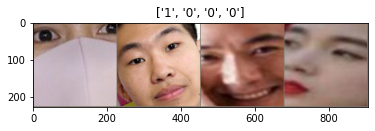

In [21]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(350),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
#             transforms.RandomResizedCrop(224),
            transforms.Resize(350),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    'test': transforms.Compose([
            transforms.Resize(350),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),    
}

data_dir = "/Dataset/MyDrive/marks/Dataset"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
# Initialize dataloader                  

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets["train"].classes

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.3436 Acc: 0.8743
val Loss: 0.1914 Acc: 0.9187

Epoch 1/4
----------
train Loss: 0.1792 Acc: 0.9437
val Loss: 0.0760 Acc: 0.9663

Epoch 2/4
----------
train Loss: 0.0603 Acc: 0.9800
val Loss: 0.0337 Acc: 0.9871

Epoch 3/4
----------
train Loss: 0.0185 Acc: 0.9947
val Loss: 0.0233 Acc: 0.9891

Epoch 4/4
----------
train Loss: 0.0122 Acc: 0.9963
val Loss: 0.0158 Acc: 0.9950

Training complete in 10m 4s
Best val Acc: 0.995040


In [17]:
# Specify a path
PATH = "/Dataset/MyDrive/marks/train.pt"

# Save
torch.save(model_ft , PATH)

In [19]:
# Model class must be defined somewhere
PATH = "/Dataset/MyDrive/marks/train.pt"
model_ft = torch.load(PATH)
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
nb_classes = 2
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders["test"]):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[[503.   1.]
 [ 12. 492.]]


In [31]:
import numpy as np

In [32]:
import numpy as np
import matplotlib



def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
  import matplotlib.pyplot as plt
  import numpy as np
  import itertools

  matplotlib.rcParams.update({'font.size': 16})

  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
    cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    
    if normalize:
      plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")
    else:
        plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()

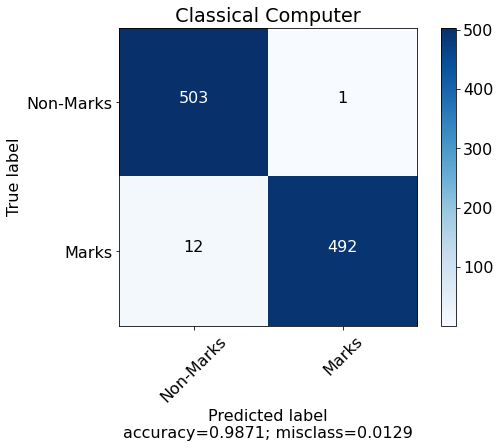

In [34]:
plot_confusion_matrix(cm  = np.array([[ 503,  1, ],
                                              [ 12,  492],
                                              ]), 
                      normalize    = False,
                      target_names = ['Non-Marks', 'Marks'],
                      title        = " Classical Computer ")

# PannyLane	BasicAer Qiskit	Cirq Simulator	Classical Computer

In [39]:
# Find Score

Recall = 503/(503+12)
print("Recall:", Recall)

Precision = 503/(503+1)
print("Precision:",Precision)

F1_score = 2*((Recall*Precision)/(Recall+Precision)) 
print("F1_score:",F1_score)

Recall: 0.9766990291262136
Precision: 0.998015873015873
F1_score: 0.9872423945044161


In [46]:
# Check on our image
import os
# PyTorch
import torch
from torchvision import transforms
from PIL import Image

test_transforms = transforms.Compose([transforms.Resize(350),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),

                                     ])

image_path = "/Dataset/MyDrive/marks/Dataset/test/0/without_mask_3325.jpg"

def predict_image(image_path):

    img = Image.open(image_path)
    print(img)
    input = test_transforms(img)
    image_tensor =  input.unsqueeze_(0)
    output = model_ft(image_tensor.cuda())
    index = output.cpu().data.numpy().argmax()
    print("Image is priditced with label O and 1 {0 mean- No Marks and 1 Means- Marks"index)

predict_image(image_path)    

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=132x126 at 0x7F4903125BD0>
0
